In [1]:
import openslide
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from shapely import Polygon

import sys
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from scripts.constants import IMAGE_MPP
image_dir = Path('../data/raw/images/pas-cpg')
annot_dir = Path('../data/raw/annotations/json_pixel')

In [2]:
wsis = []
for image in image_dir.iterdir():
    image_name = '_'.join(image.name.split('_')[:2])
    annot_comb = annot_dir / (image_name + '_inflammatory-cells.json')
    annot_lymph = annot_dir / (image_name + '_lymphocytes.json')
    annot_mono = annot_dir / (image_name + '_monocytes.json')

    slide = openslide.OpenSlide(image)
    w_mm = slide.dimensions[0] * IMAGE_MPP / 1000
    h_mm = slide.dimensions[1] * IMAGE_MPP / 1000
    line = {'image': image_name, 'width': slide.dimensions[0], 'height': slide.dimensions[1], 'area': w_mm * h_mm}
    slide.close()

    with annot_comb.open() as f:
        annot = json.load(f)
        line.update({'cells': len(annot['points']), 'rois': len(annot['rois'])})

    with annot_lymph.open() as f:
        annot = json.load(f)
        if len(annot['rois']) != line['rois']:
            print(f'{image_name}: inconsistent number of ROIs')
        line.update({'lymphocytes': len(annot['points'])})

    with annot_mono.open() as f:
        annot = json.load(f)
        if len(annot['rois']) != line['rois']:
            print(f'{image_name}: inconsistent number of ROIs')
        line.update({'monocytes': len(annot['points'])})

    if line['cells'] != line['lymphocytes'] + line['monocytes']:
        print(f'{image_name}: inconsistent number of cells')

    wsis.append(line)

wsis = pd.DataFrame(wsis)
print(f'Image number: {len(wsis)}')
print(f'Cell number: {sum(wsis['cells'])}')

Image number: 81
Cell number: 90367


In [3]:
wsis.describe()

,width,height,area,cells,rois,lymphocytes,monocytes
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,67021.432099,126934.913580,511.746516,1115.641975,2.024691,729.641975,386.000000
std,20973.041966,38392.307641,240.089490,936.278862,0.836291,679.426363,359.883974
min,36352.000000,50176.000000,139.489541,62.000000,1.000000,4.000000,47.000000
25%,45056.000000,91648.000000,335.002876,469.000000,2.000000,209.000000,162.000000
50%,64512.000000,135424.000000,512.792167,948.000000,2.000000,512.000000,251.000000
75%,89088.000000,156160.000000,694.415655,1496.000000,2.000000,1063.000000,423.000000
max,98048.000000,188928.000000,1084.835917,4674.000000,5.000000,3257.000000,1903.000000


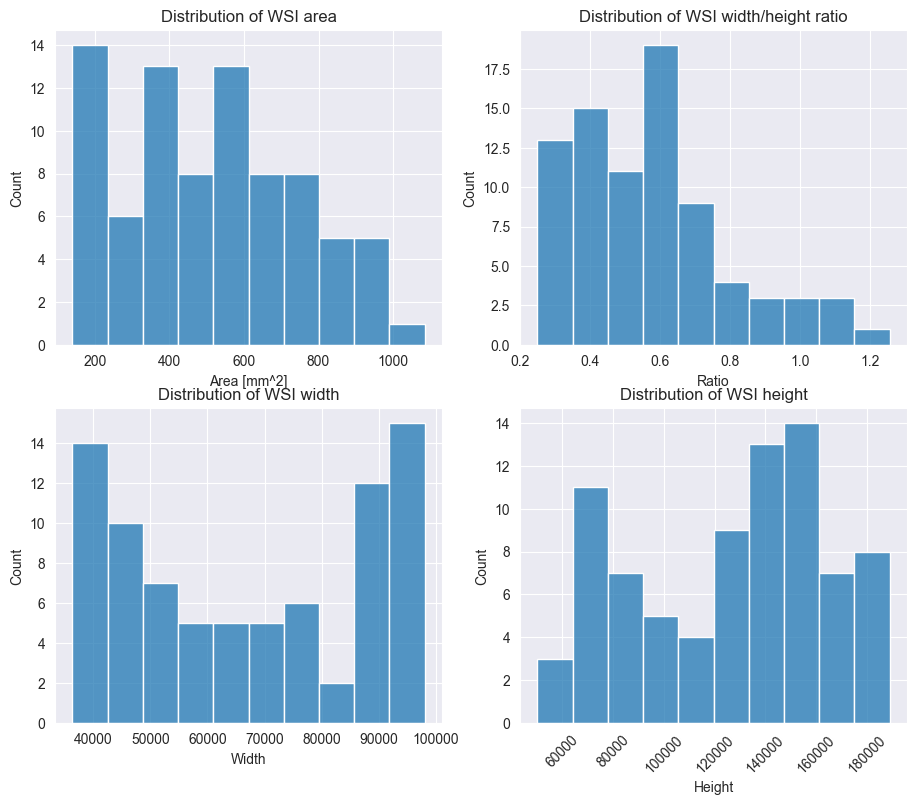

In [4]:
_, axs = plt.subplots(2, 2, figsize=(11, 9))

sns.histplot(wsis.area, bins = 10, ax=axs[0, 0])
sns.histplot(wsis.width / wsis.height, bins=10, ax=axs[0, 1])
sns.histplot(wsis.width, bins=10, ax=axs[1, 0])
sns.histplot(wsis.height, bins=10, ax=axs[1, 1])

axs[0, 0].set_title('Distribution of WSI area')
axs[0, 0].set_xlabel('Area [mm^2]')
axs[0, 1].set_title('Distribution of WSI width/height ratio')
axs[0, 1].set_xlabel('Ratio')
axs[1, 0].set_title('Distribution of WSI width')
axs[1, 0].set_xlabel('Width')
axs[1, 1].set_title('Distribution of WSI height')
axs[1, 1].set_xlabel('Height')
axs[1, 1].xaxis.set_tick_params(rotation=45)
plt.show()

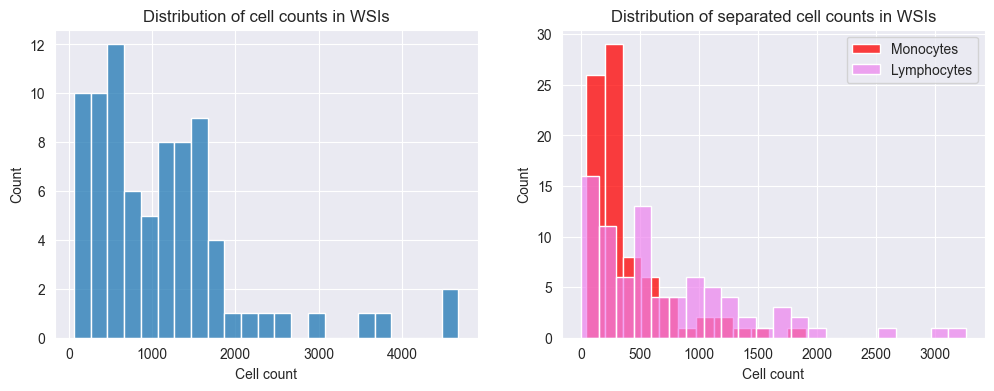

In [5]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(wsis.cells, binwidth=200, ax=axs[0])
sns.histplot(wsis.monocytes, binwidth=150, color='Red', ax=axs[1], label='Monocytes')
sns.histplot(wsis.lymphocytes, binwidth=150, color='Violet', alpha=0.7, ax=axs[1], label='Lymphocytes')

axs[0].set_xlabel('Cell count')
axs[1].set_xlabel('Cell count')
axs[0].set_title('Distribution of cell counts in WSIs')
axs[1].set_title('Distribution of separated cell counts in WSIs')
axs[1].legend()
plt.show()

In [6]:
rois = []
for image in image_dir.iterdir():
    image_name = '_'.join(image.name.split('_')[:2])
    annot_comb = annot_dir / (image_name + '_inflammatory-cells.json')
    annot_lymph = annot_dir / (image_name + '_lymphocytes.json')
    annot_mono = annot_dir / (image_name + '_monocytes.json')

    with annot_comb.open() as f:
        annot = json.load(f)
        for roi in annot['rois']:
            polygon = np.array(roi['polygon'])
            top = np.min(polygon[:, 1])
            bottom = np.max(polygon[:, 1])
            left = np.min(polygon[:, 0])
            right = np.max(polygon[:, 0])

            cell_cnt = 0
            for point in annot['points']:
                if left <= point['point'][0] <= right and top <= point['point'][1] <= bottom:
                    cell_cnt += 1

            with annot_lymph.open() as f:
                a = json.load(f)
                lymph_cnt = 0
                for point in a['points']:
                    if left <= point['point'][0] <= right and top <= point['point'][1] <= bottom:
                        lymph_cnt += 1

            with annot_mono.open() as f:
                a = json.load(f)
                mono_cnt = 0
                for point in a['points']:
                    if left <= point['point'][0] <= right and top <= point['point'][1] <= bottom:
                        mono_cnt += 1

            if cell_cnt != lymph_cnt + mono_cnt:
                print(f'{image_name} ROI: inconsistent number of cells')

            area = Polygon(polygon).area
            area_mm = area * IMAGE_MPP * IMAGE_MPP / 1000 / 1000
            rois.append({'image': image_name, 'width': right - left, 'height': bottom - top, 'area': area_mm,
                         'cells': cell_cnt, 'lymphocytes': lymph_cnt, 'monocytes': mono_cnt})

rois = pd.DataFrame(rois)
print(f'ROI number: {len(rois)}')

ROI number: 164


In [7]:
rois.describe()

,width,height,area,cells,lymphocytes,monocytes
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,2698.332237,2416.387849,0.313771,550.871951,360.335366,190.536585
std,1017.327949,817.853060,0.216824,519.578854,391.447421,184.501065
min,919.910200,936.781000,0.042593,9.000000,0.000000,4.000000
25%,1958.259775,1807.468508,0.153968,218.250000,96.750000,68.500000
50%,2481.283200,2332.388850,0.260536,381.500000,220.500000,137.000000
75%,3328.225825,2919.439725,0.435785,762.000000,509.000000,241.750000
max,5846.371100,5094.845700,1.232990,3520.000000,2614.000000,1161.000000


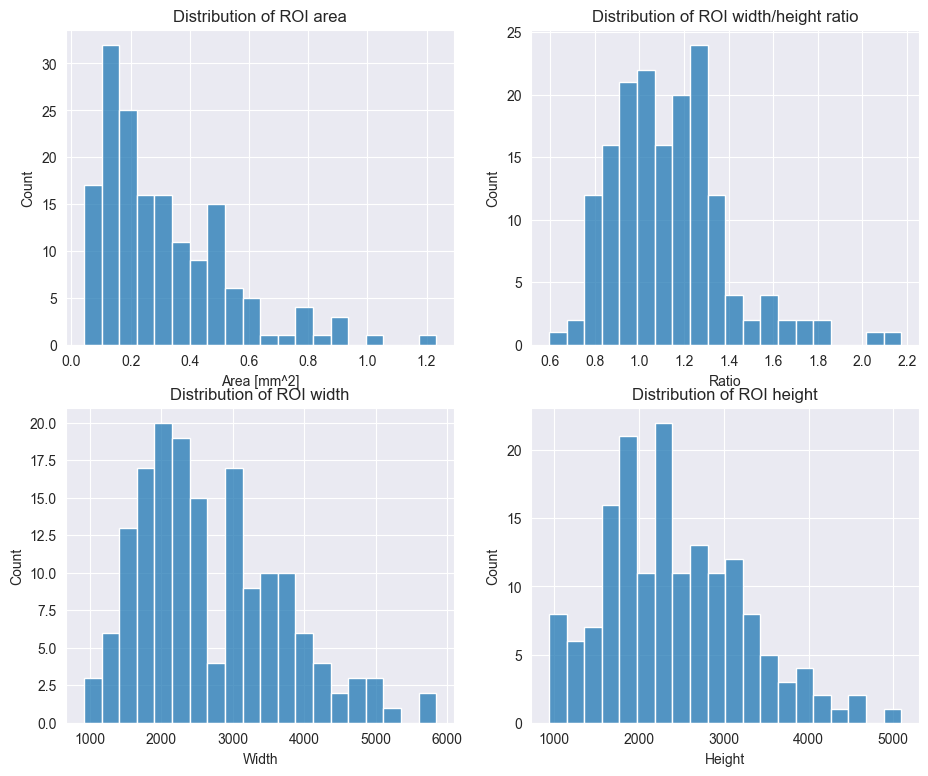

In [8]:
_, axs = plt.subplots(2, 2, figsize=(11, 9))

sns.histplot(rois.area, bins = 20, ax=axs[0, 0])
sns.histplot(rois.width / rois.height, bins=20, ax=axs[0, 1])
sns.histplot(rois.width, bins=20, ax=axs[1, 0])
sns.histplot(rois.height, bins=20, ax=axs[1, 1])

axs[0, 0].set_title('Distribution of ROI area')
axs[0, 0].set_xlabel('Area [mm^2]')
axs[0, 1].set_title('Distribution of ROI width/height ratio')
axs[0, 1].set_xlabel('Ratio')
axs[1, 0].set_title('Distribution of ROI width')
axs[1, 0].set_xlabel('Width')
axs[1, 1].set_title('Distribution of ROI height')
axs[1, 1].set_xlabel('Height')
plt.show()

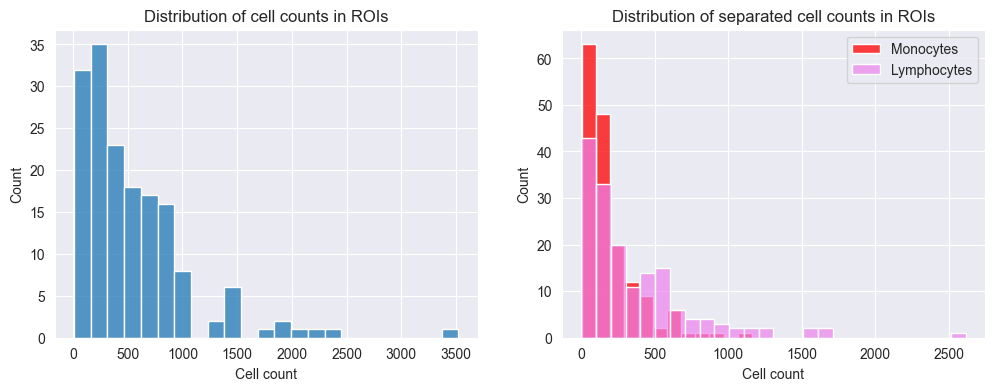

In [9]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(rois.cells, binwidth=150, ax=axs[0])
sns.histplot(rois.monocytes, binwidth=100, color='Red', ax=axs[1], label='Monocytes')
sns.histplot(rois.lymphocytes, binwidth=100, color='Violet', alpha=0.7, ax=axs[1], label='Lymphocytes')

axs[0].set_xlabel('Cell count')
axs[1].set_xlabel('Cell count')
axs[0].set_title('Distribution of cell counts in ROIs')
axs[1].set_title('Distribution of separated cell counts in ROIs')
axs[1].legend()
plt.show()